# Imports

In [1]:
import warnings
import os
import glob
import pickle
import torch
import lightning.pytorch as pl
import numpy as np
import sys
from argparse import ArgumentParser
from collections import defaultdict
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.tuner import Tuner


In [2]:
# UNIX
working_dir = "/Users/andry/Documents/GitHub/lus-dl-framework"
dataset_h5_path = "data/iclus/dataset.h5"
hospitaldict_path = "data/iclus/hospitals-patients-dict.pkl"

# Windows
# working_dir = "../."
# dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
# hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"


sys.path.append(working_dir)
os.chdir(working_dir)
os.getcwd()

from utils import *
from callbacks import *
from run_model import *
from get_sets import get_sets, get_class_weights

import sys
sys.path.append(working_dir)
from data_setup import HDF5Dataset, FrameTargetDataset, split_dataset, reduce_sets
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule


# Args

In [3]:
from argparse import ArgumentParser
import json
import sys

# ------------------------------ Parse arguments ----------------------------- #
def parse_arguments(args=None):
    if args is None:
        # If no arguments are provided, use the command-line arguments of the notebook
        args = sys.argv[1:]

    # Parse command-line arguments
    parser = ArgumentParser()

    allowed_models = ["google_vit", 
                      "swin_tiny",
                    "resnet18",
                    "resnet10",
                    "resnet50",
                    "beit", 
                    'timm_bot', 
                    "botnet18", 
                    "botnet50",
                    "vit",
                    "swin_vit",
                    "simple_vit"]

    allowed_modes = ["train", "test", "train_test", "tune"]
    parser.add_argument("--model", type=str, choices=allowed_models)
    parser.add_argument("--mode", type=str, choices=allowed_modes)
    parser.add_argument("--version", type=str)
    parser.add_argument("--working_dir_path", type=str)
    parser.add_argument("--dataset_h5_path", type=str)
    parser.add_argument("--hospitaldict_path", type=str)
    
    parser.add_argument("--trim_data", type=float)
    parser.add_argument("--trim_train", type=float)
    parser.add_argument("--trim_test", type=float)
    parser.add_argument("--trim_val", type=float)
    
    parser.add_argument('--ratios', nargs='+', type=float, help='Sets ratios')


    parser.add_argument("--chkp", type=str)
    parser.add_argument("--rseed", type=int)
    parser.add_argument("--train_ratio", type=float)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--optimizer", type=str, default="sgd")
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--weight_decay", type=float, default=0.001)
    parser.add_argument("--momentum", type=float, default=0.001)
    parser.add_argument("--label_smoothing", type=float, default=0.1)
    parser.add_argument("--drop_rate", type=float, default=0.1)
    parser.add_argument("--max_epochs", type=int, default=1)
    parser.add_argument("--num_workers", type=int, default=4)
    parser.add_argument("--accumulate_grad_batches", type=int, default=4)
    parser.add_argument("--precision", default=32)
    parser.add_argument("--disable_warnings", dest="disable_warnings", action='store_true')
    parser.add_argument("--pretrained", dest="pretrained", action='store_true')
    parser.add_argument("--freeze_layers", type=str)
    parser.add_argument("--test", dest="test", action='store_true')
    parser.add_argument("--mixup", dest="mixup", action='store_true')
    parser.add_argument("--augmentation", dest="augmentation", action='store_true')
    parser.add_argument("--summary", dest="summary", action='store_true')
    

    # Add an argument for the configuration file
    parser.add_argument('--config', type=str, help='Path to JSON configuration file')

    args = parser.parse_args(args)

    # -------------------------------- json config ------------------------------- #

    config_path = 'configs/configs.json'
    selected_config = None
    # If a configuration file was provided, load it
    if args.config:
        with open(config_path, 'r') as f:
            configurations = json.load(f)
        for config in configurations:
            if config['config'] == args.config:
                selected_config = config
                break

        # Override the command-line arguments with the configuration file
        for key, value in selected_config.items():
            if hasattr(args, key):
                setattr(args, key, value)
                
        # Check and set the ratios
        if "ratios" in selected_config:
            ratios = selected_config["ratios"]
            if len(ratios) != 3 or sum(ratios) != 1:
                parser.error('Invalid ratios provided in the configuration file')
            
        
    print(f"args are: {args}")

    return args


In [4]:
args_list = ['--model', 'swin_tiny', 
             '--mode', 'train', 
             '--batch_size', '64',
             '--dataset_h5_path', f'{dataset_h5_path}',
             '--hospitaldict_path', f'{hospitaldict_path}',
             '--working_dir_path', f'{working_dir}',
             '--ratios', '0.6', '0.2', '0.2',
             '--rseed', '418',
             '--optimizer', 'adamw',
             '--lr', '0.00002',
             '--weight_decay', '0.0001',
             '--momentum', '0.9',
             '--label_smoothing', '0',
             '--drop_rate', '0.3',
             '--max_epochs', '10',
             '--num_workers', '0',
             '--accumulate_grad_batches', '1',
             '--precision', '32',
             '--disable_warnings',
            #  '--mixup',
             '--augmentation',
            #  '--summary',
             '--pretrained',
            #  '--freeze_layers', '0',
             
             ]

In [5]:
args = parse_arguments(args_list)

args are: Namespace(model='swin_tiny', mode='train', version=None, working_dir_path='/Users/andry/Documents/GitHub/lus-dl-framework', dataset_h5_path='data/iclus/dataset.h5', hospitaldict_path='data/iclus/hospitals-patients-dict.pkl', trim_data=None, trim_train=None, trim_test=None, trim_val=None, ratios=[0.6, 0.2, 0.2], chkp=None, rseed=418, train_ratio=None, batch_size=64, optimizer='adamw', lr=2e-05, weight_decay=0.0001, momentum=0.9, label_smoothing=0.0, drop_rate=0.3, max_epochs=10, num_workers=0, accumulate_grad_batches=1, precision='32', disable_warnings=True, pretrained=True, freeze_layers=None, test=False, mixup=False, augmentation=True, summary=False, config=None)


In [6]:
import warnings

pl.seed_everything(args.rseed)
if args.disable_warnings: 
    print("Warnings are DISABLED!\n\n")
    warnings.filterwarnings("ignore")
else:
    warnings.filterwarnings("default")

Global seed set to 418


Warnings are DISABLED!




# Get Datasets

In [7]:
sets, split_info = get_sets(args)
lus_data_module = LUSDataModule(sets["train"], 
                                sets["test"],
                                sets["val"],
                                args.num_workers, 
                                args.batch_size,
                                args.mixup)


image_mean: [0.12516, 0.12867, 0.13234]
image_std: [0.16526, 0.16911, 0.1752]

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.
Split ratios: [0.6, 0.2, 0.2]

Serialized splits found, loading ...

Train size: 33544, Test size: 13555, Val size: 11825

Transforms:
TrainPreprocess()


Transforms:
Preprocess()


Transforms:
Preprocess()

Train size: 33544
Test size: 13555
Validation size: 11825


In [8]:
weight_tensor = get_class_weights((sets["train_indices"] + sets["val_indices"]), split_info)

[1.         1.4220192  1.05346277 3.42650656]


# Data

## Get dataset mean and standard deviation

In [9]:
device = torch.device('mps')
device

device(type='mps')

In [10]:
train_dataloader = lus_data_module.train_dataloader()
train_dataloader.shuffle = False

Use MixUp augmentation: False


# CAM

In [89]:
args.chkp = "checkpoints/optuna/swin_tiny_adamw/trial_19/epoch=26-val_loss=1.4048-val_f1=0.6637-val_acc=0.6732.ckpt"

model = LUSModelLightningModule.load_from_checkpoint(args.chkp,
                                                     strict=False,
                                                     map_location=torch.device('mps'))
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.0.9.post0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file checkpoints/optuna/swin_tiny_adamw/trial_19/epoch=26-val_loss=1.4048-val_f1=0.6637-val_acc=0.6732.ckpt`



Using pretrained weights: True

Using augmentation: True
Sequential(
  (0): RandomAffine(degrees=[-20.0, 20.0], translate=(0.15, 0.15), scale=(1.0, 1.15))
  (1): RandomHorizontalFlip(p=0.5)
  (2): ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=None, hue=(-0.3, 0.3))
  (3): Normalize(mean=[0.1154, 0.11836, 0.12134], std=[0.15844, 0.16195, 0.16743])
)


LUSModelLightningModule(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384

In [105]:
from pytorch_grad_cam import GradCAMPlusPlus, ScoreCAM, AblationCAM, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


#SwinViT
def swin_reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def denormalize_tensor(image_tensor):
    
    mean=torch.tensor([0.1154, 0.11836, 0.12134])
    std=torch.tensor([0.15844, 0.16195, 0.16743])
    
    """Denormalize a normalized image tensor."""
    denormalize_transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=1 / std),
        transforms.Normalize(mean=-mean, std=[1, 1, 1])
    ])
    denormalized_tensor = denormalize_transform(image_tensor)
    
    return denormalized_tensor


def generate_and_display_CAM(image_tensor, cam_model, target_layers, cam_method="gradcamplusplus", target_class=None):
    
    if cam_method == "scorecam":
        cam = ScoreCAM(model=cam_model, target_layers=target_layers)
    elif cam_method == "ablationcam":
        cam = AblationCAM(model=cam_model, target_layers=target_layers)
    else:
        cam = GradCAMPlusPlus(model=cam_model, 
                              reshape_transform=swin_reshape_transform,
                              target_layers=target_layers)
    # Prepare the input tensor
    cam_input_tensor = image_tensor.unsqueeze(0)
    
    targets = None
    if target_class is not None:
        targets=[ClassifierOutputTarget(target_class)]

    # targets = [0, 1, 2, 3]
    # Generate CAM
    grayscale_cams = cam(input_tensor=cam_input_tensor, 
                        #  aug_smooth=True,
                         eigen_smooth=True,
                         targets=targets)
    
    # Convert the input tensor to a numpy image
    image_tensor = denormalize_tensor(image_tensor)
    image = np.float32(transforms.ToPILImage()(image_tensor)) / 255
    
    # Show CAM on the image
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True, image_weight=0.75)
    
    # Convert CAM to BGR format for display
    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    
    # Display the original image and the associated CAM
    images = np.hstack((np.uint8(255 * image), cam_image))
    return Image.fromarray(images)



Idx: 1500, Target: 1, Predicted: 1


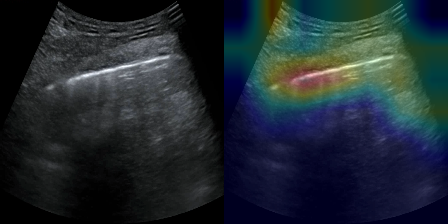

In [106]:
test_dataset = sets["test"]
# List of image indices you want to display
# image_indices_to_plot = list(range(0, len(test_dataset), 10))

# Class to target
target_class = None

# select the gradcam method
cam_method = "gradcamplusplus"
# cam_method = "scorecam"
# cam_method = "ablationcam"
    
# Specify the target layers for CAM
target_layers = [model.model.layers[-1].blocks[-1].norm2]
# target_layers = [model.model.norm]
# target_layers = [model.model.layer4[-1]]
# target_layers = [model.model.layer[1]]
# target_layers = [model.model.transformer.layers[5][0].dropout]

# Load the image tensor
image_idx = 1500
image_tensor = test_dataset[image_idx][0].to(device)

# Usage
displayed_image = generate_and_display_CAM(image_tensor, model, target_layers, target_class=target_class, cam_method=cam_method)
print(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image_tensor.unsqueeze(0))[0].argmax()}")
displayed_image

In [102]:
model.model.layers[-1].blocks[-1]

SwinTransformerBlock(
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): WindowAttention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
    (softmax): Softmax(dim=-1)
  )
  (drop_path1): DropPath(drop_prob=0.100)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (drop_path2): DropPath(drop_prob=0.100)
)

In [51]:
test_dataset = sets["test"]

# Class to target
target_class = None

# select the gradcam method
cam_method = "gradcamplusplus"
# cam_method = "scorecam"
# cam_method = "ablationcam"
    
    
# Specify the target layers for CAM
target_layers = [model.model.layers[-1].blocks[-1].norm2]
# target_layers = [model.model.layer4[-1]]
# target_layers = [model.model.layer[1]]
# target_layers = [model.model.transformer.layers[5][0].dropout]
    

In [107]:
# List of image indices you want to display
image_indices_to_plot = list(range(0, len(test_dataset), 100))

# Class to target
target_class = None

cam_method = "gradcamplusplus"
# cam_method = "scorecam"
# cam_method = "ablationcam"

# Specify the target layers for CAM
target_layers = [model.model.layers[-1].blocks[-1].norm2]
# target_layers = [model.model.layer4[-1]]
# target_layers = [model.model.layer[1]]
# target_layers = [model.model.transformer.layers[5][0].dropout]


# Create subplots for the selected images with a larger figsize
# num_maps = activation_maps.size(1)  # Get the total number of activation maps
num_rows = len(image_indices_to_plot)  # Calculate the number of rows needed
num_images = len(image_indices_to_plot)
fig, axes = plt.subplots(num_rows, 1, figsize=(20, 4 * num_rows))  # Adjust the figsize as per your preference

for i, image_idx in enumerate(image_indices_to_plot):
    image_tensor = test_dataset[image_idx][0].to(device)
    displayed_image = generate_and_display_CAM(image_tensor, model, target_layers, cam_method=cam_method, target_class=target_class)
    
    axes[i].imshow(displayed_image)
    axes[i].set_title(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image_tensor.unsqueeze(0))[0].argmax()}")
    axes[i].axis('off')
plt.show()